In [7]:
import nltk

from collections import Counter

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F

from tqdm.auto import tqdm

import re

In [2]:
read_json = True
parquet_path = 'D:/Documentos/Estudos/Projeto-NLP/dataset/yelp_academic_dataset_review.parquet'
json_path = 'D:/Documentos/Estudos/Projeto-NLP/dataset/yelp_academic_dataset_review.json'
glove_path = 'D:/Documentos/Estudos/Projeto-NLP/dataset/glove.twitter.27B.100d.txt'

if read_json:

    df = pd.DataFrame()
    for chunk in pd.read_json(json_path, lines= True, chunksize= 100000):
        df = pd.concat([df, chunk[['stars', 'text']]])

    

In [10]:
# Ler uma fração do código
df_chunk = next(pd.read_json(json_path, lines= True, chunksize= 1000, ))[['stars', 'text']]

In [5]:
print(f'Tamanho do dataset: {df.shape}')
print(f'Colunas: {df.columns.values}')

Tamanho do dataset: (6990280, 2)
Colunas: ['stars' 'text']


In [6]:
df.head()

,stars,text
0,3,"If you decide to eat here, just be aware it is..."
1,5,I've taken a lot of spin classes over the year...
2,3,Family diner. Had the buffet. Eclectic assortm...
3,5,"Wow! Yummy, different, delicious. Our favo..."
4,4,Cute interior and owner (?) gave us tour of up...


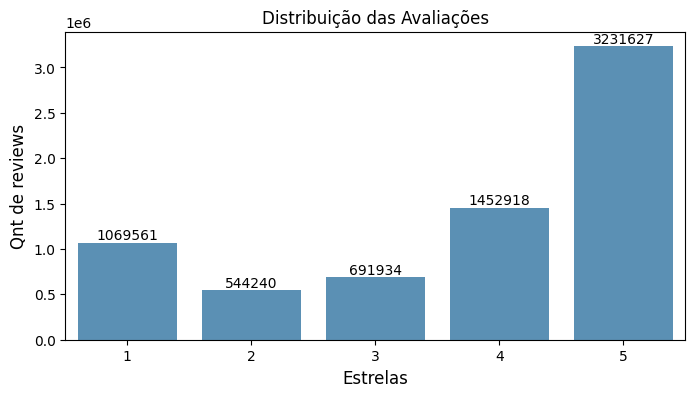

In [47]:
x = df['stars'].value_counts()
x=x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(x= x.index, y= x.values, alpha=0.8)
plt.title("Distribuição das Avaliações")
plt.ylabel('Qnt de reviews', fontsize=12)
plt.xlabel('Estrelas', fontsize=12)

rects = ax.patches
labels = x.values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha='center', va='bottom')

# Ajusta os rótulos do eixo x para ir de 1 a 5
plt.xticks(ticks=x.index - 1, labels=x.index)

plt.show()


In [46]:
print('Amostra de um texto:\n')
print('.\n'.join((df['text'].sample(1, random_state= 45).values[0]).split('.')))

Amostra de um texto:

Great food!! Service was friendly and welcoming.
 I will definitely be back!  I love the curry recipes and garlic naan


In [48]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

def clean_text(text):
    text = re.sub(r"[^\w\s']", '', str(text))
    return ' '.join(tokenizer.tokenize(str(text))).lower()



df['text'] = df['text'].apply(clean_text)

KeyboardInterrupt: 

In [13]:
data_val, data_test = train_test_split(df, test_size= 0.1, random_state= 42)
data_train, data_val = train_test_split(data_val, test_size= 0.222)

print(data_val.shape, data_test.shape, data_train.shape)

(19980, 2) (10000, 2) (70020, 2)


In [14]:
data_train.head()

,stars,text
36209,5,stromboli 795 look at the size of this and wit...
86874,1,if i could give no stars i would we order iced...
64802,5,i was looking for a lunch spot near the boeing...
56609,5,karma has been catering delicious salads for m...
51581,5,this place is amazing every time my only thoug...


In [15]:
all_text = ' '.join(data_train['text'].values)

all_tokens = tokenizer.tokenize(all_text)

tokens_count = Counter(all_tokens)

In [16]:
tokens_count.most_common(10)

[('the', 365921),
 ('and', 252126),
 ('i', 206887),
 ('a', 186817),
 ('to', 163291),
 ("'", 133860),
 ('was', 130913),
 ('it', 106521),
 ('of', 103077),
 ('is', 88560)]

In [17]:

tokens =  sorted(t for t, c in tokens_count.items() if c >= 10)
                 
UNK, PAD = "UNK", "PAD"

tokens = [UNK, PAD] + tokens

In [18]:
len(tokens)

14228

In [19]:
token_to_id = {k: i for i, k in enumerate(tokens)}